In [1]:
%autosave 180
%load_ext autoreload
%autoreload 2

Autosaving every 180 seconds


In [2]:
%%capture
!pip install catboost
!pip install shap

In [3]:
import catboost
from catboost import CatBoostRanker, Pool, MetricVisualizer, cv
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.set_option('display.max_colwidth', None)
import os
import gc
catboost.__version__

'1.0.5'

In [7]:
from features_dict import features
from utils import flatten_list
cols_to_use = flatten_list(features.values())
print(len(cols_to_use))
df = pd.read_csv('terrible_226feats_5tunes/outputs/shaps_df_trained_on_train_stopped_on_val.csv')
df[df['feature'].isin(cols_to_use)].sort_values('shap', ascending=True)#.head(50)

215


,feature,shap
149,booking_prob_train,0.000902
57,trip_start_date_week,0.000991
154,max_price_per_day_per_srch_destination_id,0.001097
153,min_price_per_day_per_srch_destination_id,0.001270
158,price_per_day_diff_to_max_price_per_day_per_srch_destination_id,0.001321
211,max_price_per_day_per_visitor_location_country_id_per_prop_country_id,0.001327
151,mean_price_per_day_per_srch_destination_id,0.001394
17,srch_children_count,0.001707
131,price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id,0.001708
150,click_prob_train,0.001718


In [55]:
df2 = pd.read_csv('friendly_stingray_245_feats_tune_2/outputs/shaps_df_trained_on_train_stopped_on_val.csv')
df2[df2['feature'].isin(cols_to_use)].sort_values('shap', ascending=True)#.head(50)

,feature,shap
155,booking_prob_train,0.000446
154,book_per_click,0.000505
66,trip_end_date_week_id,0.000540
59,trip_start_date_week,0.000645
160,max_price_per_day_per_srch_destination_id,0.000700
60,trip_start_date_week_mid_summer_index,0.000732
185,mean_price_per_day_per_prop_country_id_per_srch_room_count_per_trip_start_date_quarter,0.000823
179,min_price_per_day_per_prop_country_id_per_trip_start_date_quarter,0.000869
63,trip_start_date_week_id,0.000897
17,srch_children_count,0.000915


In [56]:
total_df = pd.merge(df, df2, on='feature')
total_df['shap_total'] = total_df['shap_x'] + total_df['shap_y']
total_df[total_df['feature'].isin(cols_to_use)].sort_values('shap_total', ascending=True)

,feature,shap_x,shap_y,shap_total
154,book_per_click,0.000781,0.000505,0.001286
155,booking_prob_train,0.000996,0.000446,0.001442
160,max_price_per_day_per_srch_destination_id,0.000957,0.000700,0.001657
59,trip_start_date_week,0.001066,0.000645,0.001710
66,trip_end_date_week_id,0.001194,0.000540,0.001735
17,srch_children_count,0.001020,0.000915,0.001935
125,max_price_per_day_per_prop_country_id,0.001159,0.001073,0.002232
63,trip_start_date_week_id,0.001339,0.000897,0.002236
60,trip_start_date_week_mid_summer_index,0.001590,0.000732,0.002321
237,min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter,0.001390,0.001052,0.002442


In [4]:
from features_dict import features
from utils import flatten_list

cols_to_use = flatten_list(features.values())
len(cols_to_use)

215

In [5]:
from features_dict import CAT_FEATURES
CAT_FEATURES = [c for c in CAT_FEATURES if c in cols_to_use]
CAT_FEATURES

['srch_id',
 'site_id',
 'prop_country_id',
 'prop_id',
 'srch_destination_id',
 'trip_start_date_week',
 'trip_end_date_week_mid_summer_index']

In [4]:
from skopt import load

res_gp = load('cold_lionfish/outputs/skopt_results.pkl')
res_gp

          fun: -0.40273841875349725
    func_vals: array([-0.40213574, -0.40215342, -0.40174767, -0.40273842])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542)]
 random_state: RandomState(MT19937) at 0x7FBA11B4A640
        space: Space([Integer(low=4, high=8, prior=

# Params

In [ ]:
# cols_to_use = (original_cols + booking_date_features + prop_location_score_features +
#                competitor_features + price_features +
#                trip_detail_features + aggregate_features + uncategorized_features +
#                star_features + price_star_features +

#                per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter +
#                per_visitor_location_country_id_per_prop_id +
#                per_day_per_prop_id_per_trip_start_date_quarter +
#                per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter +
#                #                per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2 +
#                price_per_day_per_visitor_location_country_id_per_prop_starrating +
#                per_srch_destination_id_per_srch_room_count_per_prop_review_score +
#                per_day_per_srch_destination_id_per_trip_start_date_quarter +
#                per_day_per_prop_country_id +
#                per_visitor_location_country_id_per_prop_review_score +
#                per_visitor_location_country_id_per_srch_destination_id +
#                per_prop_id +
#                per_day_per_srch_destination_id_per_prop_review_score +
#                per_trip_start_date_month +
#                per_day_per_trip_start_date_quarter +
#                target_features +
#                per_day_per_srch_destination_id +
#                per_srch_destination_id_per_prop_starrating +
#                per_day_per_prop_country_id_per_trip_start_date_quarter +
#                per_day_per_prop_country_id_per_srch_room_count_per_trip_start_date_quarter +
#                per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating +
#                per_day_per_visitor_location_country_id_per_prop_country_id_per_trip_start_date_quarter +
#                per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score +
#                per_day_per_trip_start_date_month_per_srch_destination_id +
#                per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score +
#                per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_review_score)

# len(cols_to_use)

In [6]:
assert len(cols_to_use) == len(set(cols_to_use)), 'some columns are duplicated'

In [321]:
# bool_cols = ['prop_brand_bool',
#              'promotion_flag',
#              'srch_saturday_night_bool',
#              'random_bool']

drop_cols = [
    'position',
    'click_bool',
    'gross_bookings_usd',
    'booking_bool',
    'train',
    'val',
    'test',
    'subm',
    'date_time',
] + [
#     'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter',
#     'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id',
#     'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
#     'price_index_per_srch_destination_id',
#     'price_per_day_diff_to_mean_price_per_day_per_prop_id_per_trip_start_date_quarter',
#     'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
#     'price_per_day_rel_diff_to_mean_price_per_day_per_prop_id_per_trip_start_date_quarter',
#     'mean_price_per_day_per_visitor_location_country_id_per_prop_starrating',
#     'price_per_day_rel_diff_to_min_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
#     'price_per_day_rel_diff_to_mean_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
#     'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
#     'price_per_day_rel_diff_to_max_price_per_day_per_prop_id_per_trip_start_date_quarter',
#     'price_usd',
    'date',
 'trip_start_date',
 'trip_end_date',
    'booking_prob_train', 'click_prob_train', 'book_per_click',
    'prop_location_score2', 'price_index_per_srch_id',
       'prop_location_score_sum_log',
       'price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
       'price_per_day_rel_diff_to_median_price_per_day_per_prop_id',
       'price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
       'price_per_day_rel_diff_to_mean_price_per_day_per_prop_id',
       'price_per_star',
       'price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
       'prop_star_review_min', 'prop_star_review_mean',
       'prop_location_score_mul_log',
       'price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
       'price_per_day_diff_to_mean_price_per_day_per_prop_id',
       'price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
       'prop_star_review_max',
       'median_price_per_day_per_visitor_location_country_id_per_prop_starrating',
       'mean_price_per_day_per_visitor_location_country_id_per_prop_starrating',
       'price_per_day_rel_diff_to_min_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter'
]

group_col = 'srch_id'
predict_item_col = 'prop_id'

DROP_DATETIME_TYPE = True

# Read data

In [322]:
data_path = 'data'

In [323]:
# # 15.05.2022 Oleg: for feature listing purposes. Do not used in modeling

# X_val = pd.read_feather(os.path.join(data_path, 'X_val.feather'))

# cols = X_val.columns.to_list()
# cols = [c for c in cols if 'per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter' not in c]
# cols = [c for c in cols if 'per_day_per_visitor_location_country_id_per_prop_id' not in c]
# # cols = [c for c in cols if 'per_day_per_prop_id_per_trip_start_date_quarter' not in c]
# # cols = [c for c in cols if 'per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter' not in c]
# # cols = [c for c in cols if 'per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2' not in c]
# # cols = [c for c in cols if 'price_per_day_per_visitor_location_country_id_per_prop_starrating' not in c]
# # cols = [c for c in cols if 'per_srch_destination_id_per_srch_room_count_per_prop_review_score' not in c]
# # cols = [c for c in cols if not c.endswith('per_day_per_srch_destination_id_per_trip_start_date_quarter')]
# # cols = [c for c in cols if not c.endswith('per_day_per_prop_country_id')]
# # cols = [c for c in cols if not c.endswith('per_visitor_location_country_id_per_prop_review_score')]
# # cols = [c for c in cols if not c.endswith('per_visitor_location_country_id_per_srch_destination_id')]
# # cols = [c for c in cols if not c.endswith('per_prop_id')]
# # cols = [c for c in cols if 'per_day_per_srch_destination_id_per_prop_review_score' not in c]
# # cols = [c for c in cols if not c.endswith('per_trip_start_date_month')]
# # cols = [c for c in cols if not c.endswith('per_day_per_trip_start_date_quarter')]
# # cols = [c for c in cols if not c.endswith('per_srch_destination_id_per_prop_starrating')]
# # cols = [c for c in cols if not c.endswith('per_day_per_prop_country_id_per_trip_start_date_quarter')]
# # cols = [c for c in cols if not c.endswith('per_day_per_prop_country_id_per_srch_room_count_per_trip_start_date_quarter')]
# # cols = [c for c in cols if not c.endswith('per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating')]
# # cols = [c for c in cols if not c.endswith('per_day_per_srch_destination_id')]
# # cols = [c for c in cols if not c.endswith('per_day_per_visitor_location_country_id_per_prop_country_id_per_trip_start_date_quarter')]
# # cols = [c for c in cols if not c.endswith('per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score')]
# # cols = [c for c in cols if not c.endswith('per_day_per_trip_start_date_month_per_srch_destination_id')]
# # cols = [c for c in cols if not c.endswith('per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score')]
# # cols = [c for c in cols if not c.endswith('per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_review_score')]
# # cols = [c for c in cols if not c.endswith('per_day_per_srch_destination_id_per_srch_room_count_per_prop_starrating')]
# # cols = [c for c in cols if 'prop_location_score2' not in c]
# # cols = [c for c in cols if 'per_day_per_visitor_location_country_id_per_prop_country_id' not in c]
# # cols = [c for c in cols if 'per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter' not in c]
# print(len(cols))
# # [c for c in cols if 'per_day_per_srch_destination_id_per_prop_review_score' in c]
# [c for c in cols if c.endswith('per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score')]
# # [c for c in cols if c.startswith('trip_start_date')]
# # sorted([c for c in cols if c not in cols_to_use])
# # [c for c in cols if c not in registered_features]


In [391]:
X_train = pd.read_feather(os.path.join(data_path, 'X_train.feather'))#, columns=cols_to_use)
X_train = X_train[[group_col, 'srch_children_count']]
# X_train = X_train[[c for c in X_train.columns if c not in drop_cols]]
y_train = pd.read_feather(os.path.join(data_path, 'y_train.feather'))['target']
print('X_train.shape', X_train.shape)
X_train.head()

X_train.shape (39546, 2)


,srch_id,srch_children_count
0,44,0
1,49,0
2,52,0
3,63,0
4,74,0


In [392]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [393]:
y_train.value_counts()

0    37793
5     1077
1      676
Name: target, dtype: int64

In [394]:
X_train.memory_usage().sum() / 1024**2

2.8228626251220703

In [395]:
# # makes sure all features are categorized
# assert set() == set(X_train.columns) - set(original_cols + booking_date_features + prop_location_score_features + competitor_features + price_features + historical_price_features + trip_detail_features + aggregate_features + uncategorized_features)

In [396]:
X_train.dtypes.value_counts()#.apply(lambda x: x.name).to_dict()

category    1
int8        1
dtype: int64

In [397]:
[c for c in X_train.columns if c in drop_cols or 'date' in c]

[]

In [398]:
train_pool = Pool(data=X_train, 
                  label=y_train,
                  group_id=X_train[group_col],
                  cat_features=X_train.select_dtypes(include=['category']).columns.tolist(),
                  )
# del X_train, y_train; gc.collect()

In [399]:
X_val = pd.read_feather(os.path.join(data_path, 'X_val.feather'))#, columns=cols_to_use)
# X_val = X_val[[c for c in X_val.columns if c not in drop_cols]]
X_val = X_val[[group_col, 'srch_children_count']]
y_val = pd.read_feather(os.path.join(data_path, 'y_val.feather'))['target']    
print('X_val.shape', X_val.shape)

X_val.shape (5032, 2)


In [400]:
y_val.value_counts()

0    4804
5     150
1      78
Name: target, dtype: int64

In [401]:
[c for c in X_val.columns if c in drop_cols or 'date_time' in c]

[]

In [402]:
val_pool = Pool(data=X_val,
                label=y_val,
                group_id=X_val[group_col],
                cat_features=X_val.select_dtypes(include=['category']).columns.tolist(),
                )

# del X_val, y_val; gc.collect()

# Fit final model

In [403]:
gc.collect()

24526

In [404]:
params = {
    "iterations": 50,
    'loss_function': 'YetiRank', # YetiRank should be faster # hints=skip_train~false
    'custom_metric': ['NDCG:top=5;type=Base;denominator=LogPosition;hints=skip_train~false'], 
    "verbose": False,
#     'early_stopping_rounds': 50,
#     'use_best_model': True,
#     'metric_period': 50,
#     "task_type": "GPU",
}

In [405]:
model = CatBoostRanker(**params)
model.fit(train_pool, eval_set=val_pool, plot=True, verbose_eval=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [406]:
model.tree_count_

1

In [20]:
model.save_model('catboost_model')

In [ ]:
from IPython.display import FileLink
FileLink(r'catboost_model')

In [ ]:
!zip -r catboost_info.zip /kaggle/working/catboost_info/

# Eval

In [12]:
# I run this locally as don't have enough capacity to train
model = CatBoostRanker()
model.load_model('trained_models/catboost_model', format='cbm')

In [22]:
model.is_fitted()

True

In [27]:
cols_to_use = model.feature_names_
len(cols_to_use)

398

In [ ]:
# from catboost.utils import eval_metric
# In ranking tasks it is not necessary to predict the same labels.
# It is important to predict the right order of objects.
# eval_metric(labels, good_predictions, 'NDCG:top=5;type=Base;denominator=LogPosition', 
#             group_id=group_ids)

In [407]:
print(model.eval_metrics(val_pool,
                         'NDCG:top=5;type=Base;denominator=LogPosition',
                         ntree_start=model.tree_count_-1))
# del val_pool; gc.collect()

{'NDCG:top=5;type=Base': [0.9953353924118316]}


In [408]:
print(model.eval_metrics(train_pool,
                         'NDCG:top=5;type=Base;denominator=LogPosition',
                         ntree_start=model.tree_count_-1))

# del train_pool; gc.collect()

{'NDCG:top=5;type=Base': [0.9958545675292894]}


In [128]:
X_test = pd.read_feather(os.path.join(data_path, 'X_test_small.feather'))#, columns=cols_to_use)
y_test = pd.read_feather(os.path.join(data_path, 'y_test_small.feather'))['target']
# X_test = pd.read_feather(os.path.join('../Personalize-Expedia-Hotel-Searches/data/', 'X_test_small.feather'), columns=cols_to_use)
# y_test = pd.read_feather(os.path.join('../Personalize-Expedia-Hotel-Searches/data/', 'y_test_small.feather'))['target']

print('X_test.shape', X_test.shape)

test_pool = Pool(data=X_test.drop('date_time', axis=1),
                label=y_test,
                group_id=X_test[group_col],
                cat_features=X_test.select_dtypes(include=['category']).columns.tolist(),
                )

print(model.eval_metrics(test_pool,
                         'NDCG:top=5;type=Base;denominator=LogPosition',
                         ntree_start=model.tree_count_-1))

del X_test, y_test, test_pool; gc.collect()

X_test.shape (27322, 466)
{'NDCG:top=5;type=Base': [0.9745234884147391]}


38

# Retrain the model on train+val, with test set as eval. The hyper parameters are frozen!  

Uncomment at the end of the competition

In [ ]:
train_val_pool = Pool(data=pd.concat([X_train, X_val], axis=0),
                      label=pd.concat([y_train, y_val], axis=0),
                      group_id=pd.concat([X_train, X_val], axis=0)[group_col],
                      cat_features=CAT_FEATURES,
                      )

In [ ]:
del X_train, X_val, y_train, y_val; gc.collect()

In [ ]:
X_test = pd.read_feather(os.path.join(data_path, 'X_test.feather'), columns=cols_to_use)
y_test = pd.read_feather(os.path.join(data_path, 'y_test.feather'))['target']
test_pool = Pool(data=X_test,
                label=y_test,
                group_id=X_test[group_col],
                cat_features=CAT_FEATURES,
                )
del X_test, y_test; gc.collect()

In [ ]:
params["iterations"] += 1000

model = CatBoostRanker(**params)
model.fit(train_val_pool, eval_set=test_pool, plot=False, verbose_eval=True)

In [ ]:
model.save_model('catboost_model')

# Make preds

In [6]:
# I run this locally as don't have enough capacity to train
model = CatBoostRanker()
model.load_model('large_tuning_400feats_sour_yak_1/outputs/catboost_model_train_val', format='cbm')

In [8]:
def predict_in_format(model, data, pool, group_col, predict_item_col, gt_col=None):
    preds = model.predict(pool)

    values = {group_col: data[group_col],
              predict_item_col: data[predict_item_col],
              'pred': preds}

    values_df = pd.DataFrame(values)
    values_df.sort_values(by=[group_col, 'pred'], ascending=[True, False], inplace=True)

    if gt_col is not None:
        values_df['gt'] = gt_col
        ndcg_score = values_df.groupby(group_col)['gt'].apply(ndcg, at=5).mean()
        print('Local test NDCG@5:', ndcg_score)

    return values_df

In [15]:
subm_df = pd.read_feather(os.path.join(
    data_path, 'submission_df_preprocessed.feather'), columns=cols_to_use)
subm_df.sort_values([group_col], inplace=True)

In [20]:
subm_name = 'submission_19'
subm_filename = f'submissions/{subm_name}.csv'
subm_scores_filename = f'submissions/{subm_name}_scores.csv'

In [18]:
from utils import prepare_cats
prepare_cats(subm_df, CAT_FEATURES)

In [19]:
subm_pool = Pool(
    data=subm_df,
    group_id=subm_df[group_col],
    cat_features=CAT_FEATURES,
)

output_df = predict_in_format(model, subm_df, subm_pool, group_col, predict_item_col)
del subm_df, subm_pool; gc.collect()
output_df.head(10)

,srch_id,prop_id,pred
23,1,99484,3.080002
9,1,54937,2.781211
5,1,28181,2.651430
12,1,61934,2.534519
22,1,95031,2.388750
4,1,24194,2.277967
6,1,34263,2.225679
18,1,82231,2.092725
1,1,5543,1.977024
8,1,50162,1.944626


In [22]:
output_df.to_csv(subm_scores_filename, index=False)
output_df[[group_col, 'prop_id']].to_csv(subm_filename, index=False)
del output_df; gc.collect()
pd.read_csv(subm_filename, nrows=10)

,srch_id,prop_id
0,1,99484
1,1,54937
2,1,28181
3,1,61934
4,1,95031
5,1,24194
6,1,34263
7,1,82231
8,1,5543
9,1,50162


In [4]:
# use locally or if you added the sample subm file to the dataset
def validate_submission(subm_sample_path, our_subm_path):
    
    subm_sample = pd.read_csv(subm_sample_path)
    our_subm = pd.read_csv(our_subm_path)
    
    assert subm_sample.shape == our_subm.shape
    assert our_subm[group_col].equals(subm_sample[group_col])
    assert our_subm.index.equals(subm_sample.index)
    assert subm_sample.groupby(group_col)['prop_id'].apply(len).to_frame().equals(
        our_subm.groupby(group_col)['prop_id'].apply(len).to_frame())
    print('everything is ok to submit')
    
validate_submission(os.path.join(data_path, 'submission_sample.csv'),
                    subm_filename)

NameError: name 'os' is not defined

# Feature importance

In [48]:
del train_pool; gc.collect()

NameError: name 'train_pool' is not defined

In [109]:
cols_to_use = ['srch_id',
               'site_id',
               'visitor_hist_starrating',
               'visitor_hist_adr_usd',
               'prop_country_id',
               'prop_id',
               'prop_starrating',
               'prop_review_score',
               'prop_brand_bool',
               'prop_location_score1',
               'prop_location_score2',
               'prop_log_historical_price',
               'price_usd',
               'promotion_flag',
               'srch_destination_id',
               'srch_booking_window',
               'srch_children_count',
               'srch_saturday_night_bool',
               'srch_query_affinity_score',
               'orig_destination_distance',
               'random_bool',
               'comp2_rate_percent_diff',
               'comp3_rate_percent_diff',
               'comp5_rate_percent_diff',
               'date_time_ordinal',
               'prop_location_score_diff',
               'prop_location_score_sum',
               'prop_location_score_mul',
               'prop_location_score_diff_log',
               'prop_location_score_sum_log',
               'prop_location_score_mul_log',
               'ratio_of_comp_with_higher_price_than_expedia',
               'ratio_of_comp_with_lower_price_than_expedia',
               'comp5_rate_percent_diff_signed',
               'comp8_rate_percent_diff_signed',
               'price_per_day',
               'price_usd_log_10',
               'visitor_hist_adr_usd_pow_0.5',
               'prop_log_historical_price_pow_0.33',
               'prop_log_historical_price_log_10',
               'prop_log_historical_price_reciprocal',
               'price_diff_to_usr_hist',
               'price_ratio_to_usr_hist',
               'price_diff_to_place_hist_price',
               'travel_inside',
               'booking_weeks_ahead',
               'len_of_stay_to_booking_ahead_ratio',
               'children_per_adult',
               'people_per_room',
               'separate_children_room',
               'trip_start_date',
               'trip_start_date_week',
               'trip_start_date_week_mid_summer_index',
               'trip_start_date_month',
               'trip_start_date_days_in_month',
               'trip_start_date_season_num',
               'trip_start_date_week_id',
               'price_index_per_srch_id',
               'price_index_per_srch_destination_id',
               'price_index_per_prop_id',
               'srch_query_affinity_score_prob',
               'prop_star_usr_hist_diff',
               'prop_review_usr_hist_diff',
               'prop_starrating_bonus_chain',
               'prop_star_review_sum',
               'prop_star_review_diff',
               'prop_star_review_min',
               'prop_star_review_max',
               'prop_star_review_mean',
               'price_per_star',
               'price_per_review_score',
               'price_per_star_log_10',
               'price_per_review_score_log_10',
               'usr_price_per_star_log_10',
               'price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
               'mean_price_per_day_per_visitor_location_country_id_per_prop_id',
               'median_price_per_day_per_visitor_location_country_id_per_prop_id',
               'max_price_per_day_per_visitor_location_country_id_per_prop_id',
               'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id',
               'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id',
               'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id',
               'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id',
               'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id',
               'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id',
               'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id',
               'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id',
               'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
               'mean_price_per_day_per_prop_id_per_trip_start_date_quarter',
               'max_price_per_day_per_prop_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_mean_price_per_day_per_prop_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_mean_price_per_day_per_prop_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_median_price_per_day_per_prop_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_median_price_per_day_per_prop_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_min_price_per_day_per_prop_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_min_price_per_day_per_prop_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_max_price_per_day_per_prop_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_max_price_per_day_per_prop_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_mean_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_mean_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_diff_to_median_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_median_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_diff_to_min_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_min_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_diff_to_max_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_max_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
               'mean_price_per_day_per_visitor_location_country_id_per_prop_starrating',
               'median_price_per_day_per_visitor_location_country_id_per_prop_starrating',
               'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_starrating',
               'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_starrating',
               'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_starrating',
               'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_starrating',
               'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_starrating',
               'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_starrating',
               'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_starrating',
               'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_starrating',
               'min_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
               'price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
               'price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
               'price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
               'price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
               'price_per_day_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
               'price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
               'price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
               'price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
               'price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
               'min_price_per_day_per_prop_country_id',
               'max_price_per_day_per_prop_country_id',
               'price_per_day_diff_to_median_price_per_day_per_prop_country_id',
               'price_per_day_rel_diff_to_median_price_per_day_per_prop_country_id',
               'price_per_day_diff_to_min_price_per_day_per_prop_country_id',
               'price_per_day_rel_diff_to_min_price_per_day_per_prop_country_id',
               'price_per_day_diff_to_max_price_per_day_per_prop_country_id',
               'price_per_day_rel_diff_to_max_price_per_day_per_prop_country_id',
               'mean_price_per_day_per_visitor_location_country_id_per_prop_review_score',
               'median_price_per_day_per_visitor_location_country_id_per_prop_review_score',
               'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_review_score',
               'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_review_score',
               'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_review_score',
               'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_review_score',
               'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_review_score',
               'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_review_score',
               'mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
               'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
               'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
               'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
               'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
               'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
               'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
               'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
               'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
               'mean_price_per_day_per_prop_id',
               'median_price_per_day_per_prop_id',
               'min_price_per_day_per_prop_id',
               'max_price_per_day_per_prop_id',
               'price_per_day_diff_to_mean_price_per_day_per_prop_id',
               'price_per_day_rel_diff_to_mean_price_per_day_per_prop_id',
               'price_per_day_diff_to_median_price_per_day_per_prop_id',
               'price_per_day_rel_diff_to_median_price_per_day_per_prop_id',
               'price_per_day_diff_to_min_price_per_day_per_prop_id',
               'price_per_day_rel_diff_to_min_price_per_day_per_prop_id',
               'price_per_day_diff_to_max_price_per_day_per_prop_id',
               'price_per_day_rel_diff_to_max_price_per_day_per_prop_id',
               'min_price_per_day_per_srch_destination_id_per_prop_review_score',
               'max_price_per_day_per_srch_destination_id_per_prop_review_score',
               'price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_prop_review_score',
               'price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_prop_review_score',
               'price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_prop_review_score',
               'price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_prop_review_score',
               'price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id_per_prop_review_score',
               'price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_prop_review_score',
               'price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id_per_prop_review_score',
               'price_per_day_diff_to_mean_price_per_day_per_trip_start_date_month',
               'price_per_day_rel_diff_to_min_price_per_day_per_trip_start_date_month',
               'prop_historical_price_rel_diff_to_min_price_per_day_per_trip_start_date_month',
               'price_per_day_diff_to_max_price_per_day_per_trip_start_date_month',
               'price_per_day_rel_diff_to_max_price_per_day_per_trip_start_date_month',
               'prop_historical_price_diff_to_max_price_per_day_per_trip_start_date_month',
               'price_per_day_rel_diff_to_mean_price_per_day_per_trip_start_date_quarter',
               'prop_historical_price_diff_to_mean_price_per_day_per_trip_start_date_quarter',
               'prop_historical_price_rel_diff_to_mean_price_per_day_per_trip_start_date_quarter',
               'prop_historical_price_rel_diff_to_min_price_per_day_per_trip_start_date_quarter',
               'price_per_day_diff_to_max_price_per_day_per_trip_start_date_quarter',
               'book_per_click',
               'booking_prob_train',
               'click_prob_train',
               'mean_price_per_day_per_srch_destination_id',
               'median_price_per_day_per_srch_destination_id',
               'min_price_per_day_per_srch_destination_id',
               'max_price_per_day_per_srch_destination_id',
               'price_per_day_diff_to_mean_price_per_day_per_srch_destination_id',
               'price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id',
               'price_per_day_diff_to_median_price_per_day_per_srch_destination_id',
               'price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id',
               'price_per_day_diff_to_min_price_per_day_per_srch_destination_id',
               'price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id',
               'price_per_day_diff_to_max_price_per_day_per_srch_destination_id',
               'price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id',
               'mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_starrating',
               'median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_starrating',
               'min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_starrating',
               'max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_starrating',
               'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_starrating',
               'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_starrating',
               'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_starrating',
               'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_starrating',
               'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_starrating',
               'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_starrating',
               'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_starrating',
               'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_starrating',
               'mean_price_per_day_per_srch_destination_id_per_prop_starrating',
               'median_price_per_day_per_srch_destination_id_per_prop_starrating',
               'min_price_per_day_per_srch_destination_id_per_prop_starrating',
               'max_price_per_day_per_srch_destination_id_per_prop_starrating',
               'price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_prop_starrating',
               'price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_prop_starrating',
               'price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_prop_starrating',
               'price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_prop_starrating',
               'price_per_day_diff_to_min_price_per_day_per_srch_destination_id_per_prop_starrating',
               'price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id_per_prop_starrating',
               'price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_prop_starrating',
               'price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id_per_prop_starrating',


               'mean_price_per_day_per_visitor_location_country_id_per_prop_country_id',
               'median_price_per_day_per_visitor_location_country_id_per_prop_country_id',
               'min_price_per_day_per_visitor_location_country_id_per_prop_country_id',
               'max_price_per_day_per_visitor_location_country_id_per_prop_country_id',
               'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_country_id',
               'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_country_id',
               'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_country_id',
               'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_country_id',
               'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_country_id',
               'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_country_id',
               'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_country_id',
               'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_country_id',
               'mean_price_per_day_per_visitor_location_country_id_per_prop_country_id_per_trip_start_date_quarter',
               'median_price_per_day_per_visitor_location_country_id_per_prop_country_id_per_trip_start_date_quarter',
               'min_price_per_day_per_visitor_location_country_id_per_prop_country_id_per_trip_start_date_quarter',
               'max_price_per_day_per_visitor_location_country_id_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_country_id_per_trip_start_date_quarter',
               'mean_price_per_day_per_prop_country_id_per_trip_start_date_quarter',
               'median_price_per_day_per_prop_country_id_per_trip_start_date_quarter',
               'min_price_per_day_per_prop_country_id_per_trip_start_date_quarter',
               'max_price_per_day_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_mean_price_per_day_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_mean_price_per_day_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_median_price_per_day_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_median_price_per_day_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_min_price_per_day_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_min_price_per_day_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_max_price_per_day_per_prop_country_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_max_price_per_day_per_prop_country_id_per_trip_start_date_quarter',
               'mean_price_per_day_per_prop_country_id_per_srch_room_count_per_trip_start_date_quarter',
               'median_price_per_day_per_prop_country_id_per_srch_room_count_per_trip_start_date_quarter',
               'min_price_per_day_per_prop_country_id_per_srch_room_count_per_trip_start_date_quarter',
               'max_price_per_day_per_prop_country_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_diff_to_mean_price_per_day_per_prop_country_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_mean_price_per_day_per_prop_country_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_diff_to_median_price_per_day_per_prop_country_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_median_price_per_day_per_prop_country_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_diff_to_min_price_per_day_per_prop_country_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_min_price_per_day_per_prop_country_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_diff_to_max_price_per_day_per_prop_country_id_per_srch_room_count_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_max_price_per_day_per_prop_country_id_per_srch_room_count_per_trip_start_date_quarter',
               'mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter',
               'median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter',
               'min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter',
               'max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter',
               'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter',
               'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter',
               'mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'mean_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'median_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'min_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'max_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_diff_to_min_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_starrating',
               'mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_starrating',
               'median_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_starrating',
               'min_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_starrating',
               'max_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_starrating',
               'price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_starrating',
               'price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_starrating',
               'price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_starrating',
               'price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_starrating',
               'price_per_day_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_starrating',
               'price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_starrating',
               'price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_starrating',
               'price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_starrating',
               'mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_review_score',
               'median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_review_score',
               'min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_review_score',
               'max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_review_score',
               'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_review_score',
               'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_review_score',
               'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_review_score',
               'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_review_score',
               'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_review_score',
               'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_review_score',
               'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_review_score',
               'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_review_score',
               'mean_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'median_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'min_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'max_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_diff_to_min_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',
               'price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id_per_trip_start_date_quarter_per_prop_review_score',

               'mean_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'median_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'min_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'max_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'sum_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'price_per_day_diff_to_mean_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'price_per_day_rel_diff_to_mean_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'visitor_hist_adr_usd_diff_to_mean_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'visitor_hist_adr_usd_rel_diff_to_mean_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'prop_historical_price_diff_to_mean_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'prop_historical_price_rel_diff_to_mean_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'price_per_day_diff_to_median_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'price_per_day_rel_diff_to_median_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'visitor_hist_adr_usd_diff_to_median_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'visitor_hist_adr_usd_rel_diff_to_median_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'prop_historical_price_diff_to_median_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'prop_historical_price_rel_diff_to_median_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'price_per_day_diff_to_min_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'price_per_day_rel_diff_to_min_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'visitor_hist_adr_usd_diff_to_min_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'visitor_hist_adr_usd_rel_diff_to_min_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'prop_historical_price_diff_to_min_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'prop_historical_price_rel_diff_to_min_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'price_per_day_diff_to_max_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'price_per_day_rel_diff_to_max_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'visitor_hist_adr_usd_diff_to_max_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'visitor_hist_adr_usd_rel_diff_to_max_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'prop_historical_price_diff_to_max_price_per_day_per_trip_start_date_month_per_srch_destination_id',
               'prop_historical_price_rel_diff_to_max_price_per_day_per_trip_start_date_month_per_srch_destination_id'
               ]

In [110]:
# del test_pool; gc.collect()

X_val = pd.read_feather(os.path.join(data_path, 'X_val.feather'), columns=cols_to_use).sample(100000)
X_val = X_val[X_val.index.isin((X_val[group_col].value_counts() > 1).index)]
X_val.sort_values(group_col, inplace=True)
y_val = pd.read_feather(os.path.join(data_path, 'y_val.feather')).loc[X_val.index, 'target']
print('X_val.shape', X_val.shape)

val_pool = Pool(data=X_val,
                label=y_val,
                group_id=X_val[group_col],
                cat_features=CAT_FEATURES,
                )

X_val.shape (3902, 398)


In [412]:
X_train[group_col].nunique(), X_val[group_col].nunique() 

(34724, 4395)

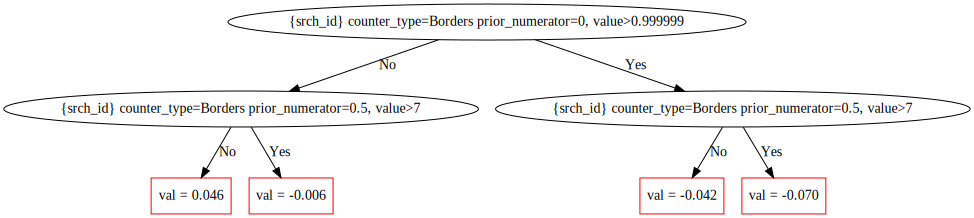

In [413]:
g = model.plot_tree(
    tree_idx=0,
    pool=val_pool
)
g

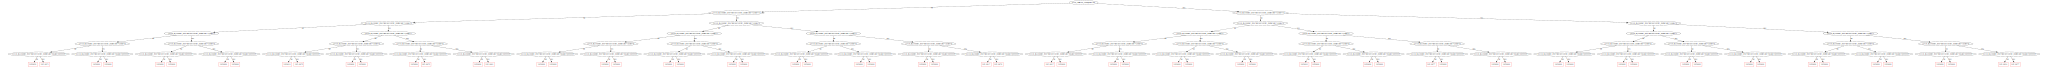

In [372]:
g = model.plot_tree(
    tree_idx=model.tree_count_-1,
    pool=val_pool
)
g

In [27]:
# g.save('tree.pdf')

In [28]:
# from feature_importance import get_and_plot_feature_imp_catboost

# COLLECT_N_IMPORTANT_FEATURES = 150

# feature_score_SHAP, shap_values_raw = get_and_plot_feature_imp_catboost(model, X_val, y_val,
#                                                                         method='SHAP',
#                                                                         cat_features=CAT_FEATURES,
#                                                                         #                                                        plot_type='bar',
#                                                                         top_n=COLLECT_N_IMPORTANT_FEATURES)

# # important_features_collected.update(feature_score_SHAP.sort_values(
# #     ['Score'], ascending=False).values[:COLLECT_N_IMPORTANT_FEATURES, 0])

In [29]:
# pd.set_option('max_rows', None)
# feature_score_SHAP.sort_values('Score', ascending=False)

# shap_values_raw

features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [414]:
import shap
shap.initjs()

explainer = shap.Explainer(model)
shap_values = explainer(X_val) # X_val or val_pool

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

In [425]:
pd.concat([X_train, y_train], axis=1).groupby(group_col)['target'].nunique().value_counts()

0    46345
1    34354
2      370
Name: target, dtype: int64

In [429]:
X_val.head()

,srch_id,srch_children_count
0,1,0
1,31,2
2,101,1
3,111,1
4,161,0


In [430]:
y_val.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [435]:
X_val[X_val['srch_id'] == 10]

,srch_id,srch_children_count


In [437]:
pd.concat([X_val, y_val], axis=1, ignore_index=True)#.groupby(group_col)['target'].apply(list)

,0,1,2
0,1,0,0
1,31,2,0
2,101,1,0
3,111,1,0
4,161,0,0
5,181,0,0
6,241,0,0
7,241,0,0
8,241,0,0
9,271,0,0


In [427]:
model.predict(val_pool)

array([-0.00559917, -0.00559917, -0.00559917, ..., -0.00559917,
       -0.00559917, -0.00559917])

In [415]:
pd.set_option('max_rows', None)
pd.set_option('display.max_colwidth', None)

import numpy as np
features = X_val.columns
mean_shaps = np.abs(shap_values.values).mean(0)
# mask = mean_shaps.argsort()[::-1]
# features[mask]
shaps_df = pd.DataFrame({'feature': features, 'shap': mean_shaps})
# shaps_df = shaps_df[shaps_df['shap'] < 0.001]
shaps_df[shaps_df['feature'].isin(cols_to_use)].sort_values('shap', ascending=False)#.head(20)['feature'].values

,feature,shap
0,srch_id,0.005599
1,srch_children_count,0.000000


In [416]:
shaps_df['per_col'] = shaps_df['feature'].apply(lambda x: ''.join(x.split('per_')[1:]))
shaps_df[shaps_df['per_col'] != ''].sort_values(['per_col', 'shap']).drop(['per_col'], axis=1)

,feature,shap


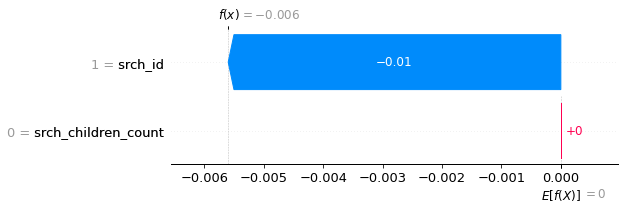

In [417]:
shap.plots.waterfall(shap_values[0])

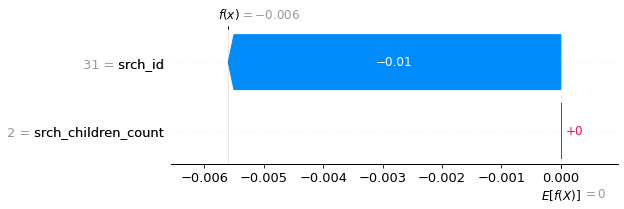

In [418]:
shap.plots.waterfall(shap_values[1])

In [419]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

In [420]:
shap.plots.force(shap_values[10])

In [421]:
# visualize all the training set predictions
shap.plots.force(shap_values[:100])

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output. Vertical dispersion at a single value represents interaction effects with other features. To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the color argument the scatter plot will pick the best feature to color by. 

In [381]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:100, "prop_location_score2"], color=shap_values[:100])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).

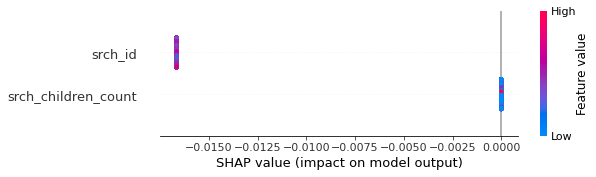

In [382]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=100)

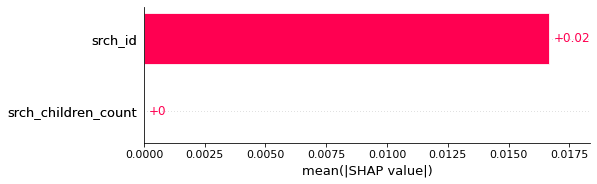

In [383]:
shap.plots.bar(shap_values, max_display=100)

SHAP interaction values are a generalization of SHAP values to higher order interactions. Fast exact computation of pairwise interactions are implemented for tree models with shap.TreeExplainer(model).shap_interaction_values(X). This returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. These values often reveal interesting hidden relationships

https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

In [ ]:
# explainer.shap_interaction_values(X_val.head(10))

In [ ]:
# feature_score_PredictionValuesChange = get_and_plot_feature_imp_catboost(
#         model, X_val, y_val,
#         cat_features=CAT_FEATURES,
#         method='PredictionValuesChange',
#         top_n=COLLECT_N_IMPORTANT_FEATURES)

#     important_features_collected.update(feature_score_PredictionValuesChange.sort_values(['Score'], ascending=False).values[:COLLECT_N_IMPORTANT_FEATURES, 0])

For each feature, LossFunctionChange represents the difference between the loss value of the model with this feature and without it.

+ more accurate than Prediction Values Change
+ more fast than Shap Values
- assumes that loss function changes for several features can be summed up

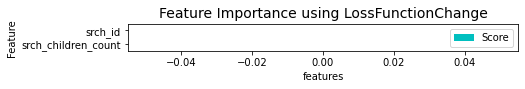

In [384]:
import matplotlib.pyplot as plt

for method in ['LossFunctionChange']:
    fi = model.get_feature_importance(val_pool, type=method)
    feature_score_raw = pd.DataFrame(list(zip(X_val.columns, fi)),
                                     columns=['Feature', 'Score'])

    feature_score = feature_score_raw.sort_values(
        by='Score', ascending=False)

    plt.rcParams["figure.figsize"] = (7, len(feature_score) / 4)
    ax = feature_score.plot('Feature', 'Score', kind='barh', color='c')
    ax.set_title("Feature Importance using {}".format(method), fontsize=14)
    ax.set_xlabel("features")
    ax.invert_yaxis()
    plt.show()

In [ ]:
feature_score.sort_values('Feature')

In [ ]:
feature_score['per_col'] = feature_score['Feature'].apply(lambda x: ''.join(x.split('per_')[1:]))
feature_score[feature_score['per_col'] != ''].sort_values('per_col').drop(['per_col'], axis=1)